### Ellipticity, shear, and convergence by redshift bin in DC2

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

---

First we'll make some exploratory plots.

In [2]:
catalog_full = pd.read_pickle('/data/scratch/dc2local/dc2_lensing_catalog.pkl')

In [3]:
# for computational efficiency, we use a subset of the above data frame
catalog = catalog_full.sample(n = 100000)

In [4]:
galid = torch.from_numpy(catalog["galaxy_id"].values)
ra = torch.from_numpy(catalog["ra"].values).squeeze()
dec = torch.from_numpy(catalog["dec"].values).squeeze()

shear1 = torch.from_numpy(catalog["shear_1"].values).squeeze()
shear2 = torch.from_numpy(catalog["shear_2"].values).squeeze()
convergence = torch.from_numpy(catalog["convergence"].values).squeeze()

redshift = torch.from_numpy(catalog["redshift"].values).squeeze()

flux_r = torch.from_numpy(catalog["flux_r"].values).squeeze()
mag_r = torch.from_numpy(catalog["mag_r"].values).squeeze()

ellip1_intrinsic = torch.from_numpy(catalog["ellipticity_1_true"].values).squeeze()
ellip2_intrinsic = torch.from_numpy(catalog["ellipticity_2_true"].values).squeeze()
ellip_intrinsic = torch.sqrt(ellip1_intrinsic ** 2 + ellip2_intrinsic ** 2)

complex_shear = shear1 + shear2 * 1j
complex_ellip = ellip1_intrinsic + ellip2_intrinsic * 1j
reduced_shear = complex_shear / (1.0 - convergence)
ellip_lensed = (complex_ellip + reduced_shear) / (1.0 + reduced_shear.conj() * complex_ellip)
ellip1_lensed = torch.view_as_real(ellip_lensed)[...,0]
ellip2_lensed = torch.view_as_real(ellip_lensed)[...,1]
ellip_lensed = torch.absolute(ellip_lensed)

We see that most galaxies are closer (redshift <= 2ish) and brighter (r-band mag <= 27ish):

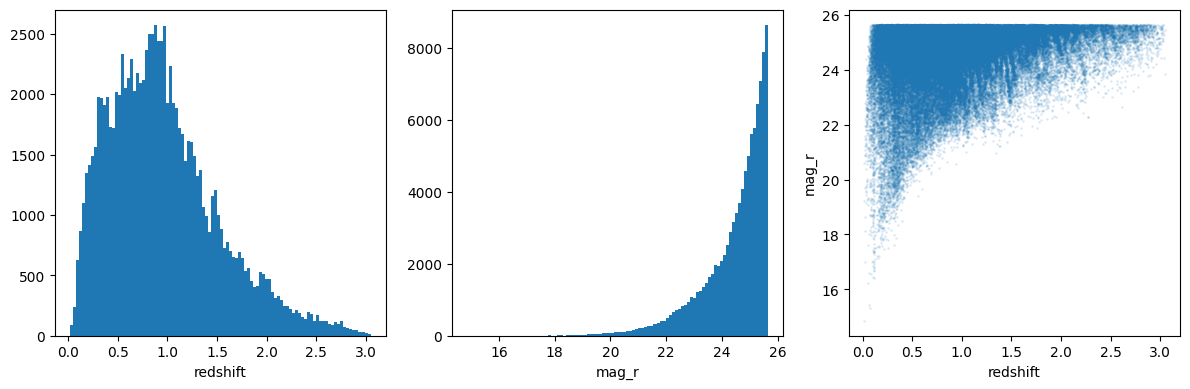

In [5]:
fig, ax = plt.subplots(1, 3, figsize = (12,4))
_ = ax[0].hist(redshift, bins = 100)
_ = ax[0].set_xlabel('redshift')
_ = ax[1].hist(mag_r, bins = 100)
_ = ax[1].set_xlabel('mag_r')
_ = ax[2].scatter(redshift, mag_r, alpha = 0.1, s = 1)
_ = ax[2].set_xlabel('redshift')
_ = ax[2].set_ylabel('mag_r')
fig.tight_layout()

Here is the distribution of ellipticity by redshift:

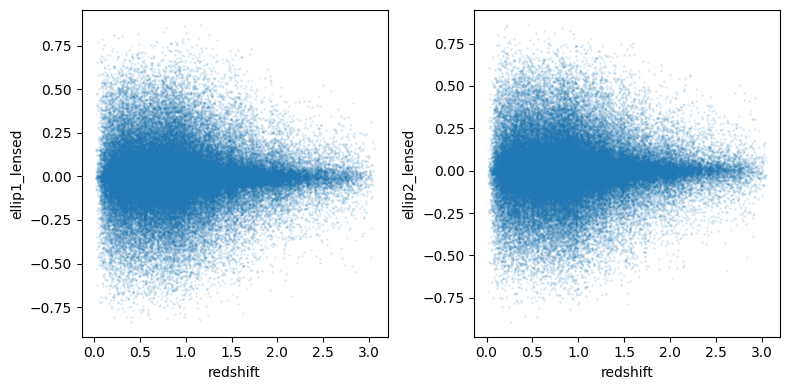

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))
_ = ax[0].scatter(redshift, ellip1_lensed, alpha = 0.1, s = 1)
_ = ax[0].set_xlabel('redshift')
_ = ax[0].set_ylabel('ellip1_lensed')
_ = ax[1].scatter(redshift, ellip2_lensed, alpha = 0.1, s = 1)
_ = ax[1].set_xlabel('redshift')
_ = ax[1].set_ylabel('ellip2_lensed')
fig.tight_layout()

And we find that galaxies farther away $\Longleftrightarrow$ more dark matter along line of sight $\Longleftrightarrow$ larger shear and convergence

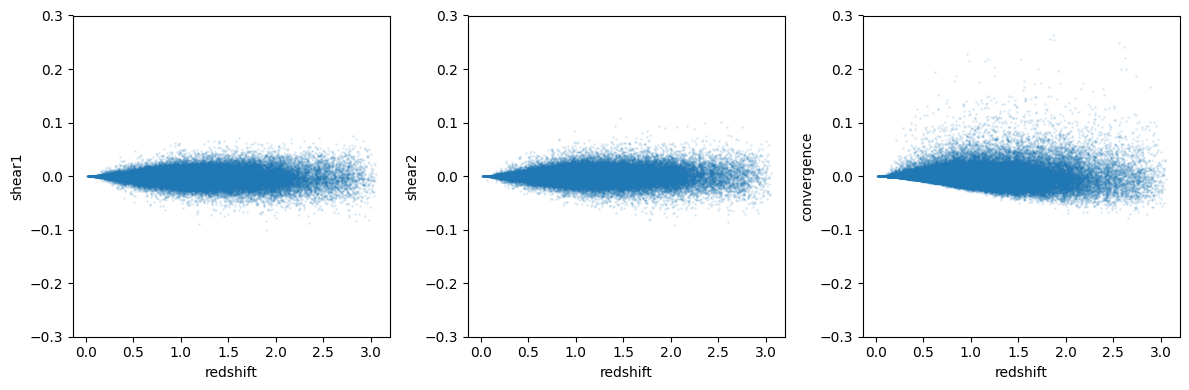

In [7]:
fig, ax = plt.subplots(1, 3, figsize = (12,4))
_ = ax[0].scatter(redshift, shear1, alpha = 0.1, s = 1)
_ = ax[0].set_xlabel('redshift')
_ = ax[0].set_ylabel('shear1')
_ = ax[0].set_ylim((-0.3, 0.3))
_ = ax[1].scatter(redshift, shear2, alpha = 0.1, s = 1)
_ = ax[1].set_xlabel('redshift')
_ = ax[1].set_ylabel('shear2')
_ = ax[1].set_ylim((-0.3, 0.3))
_ = ax[2].scatter(redshift, convergence, alpha = 0.1, s = 1)
_ = ax[2].set_xlabel('redshift')
_ = ax[2].set_ylabel('convergence')
_ = ax[2].set_ylim((-0.3, 0.3))
fig.tight_layout()

---

Now we'll load in one 2048 $\times$ 2048 image and look at spatial variation in shear, convergence, ellipticity, and redshift.

In [8]:
from hydra import initialize, compose
from hydra.utils import instantiate
from bliss.surveys.dc2 import split_tensor, unpack_dict

with initialize(config_path="../../", version_base = None):
    cfg = compose("lensing_config")

In [9]:
dc2 = instantiate(cfg.surveys.dc2)
dc2._load_image_and_bg_files_list()

98

In [10]:
# this cell takes 10-20 seconds
image_index = 1
result_dict = dc2.load_image_and_catalog(image_index)

In [11]:
plocs = result_dict['other_info']['full_cat']['plocs']
shear1 = result_dict['other_info']['full_cat']['shear1']
shear2 = result_dict['other_info']['full_cat']['shear2']
convergence = result_dict['other_info']['full_cat']['convergence']
redshift = result_dict['other_info']['full_cat']['redshift']
ellip1_lensed = result_dict['other_info']['full_cat']['ellip1_lensed']
ellip2_lensed = result_dict['other_info']['full_cat']['ellip2_lensed']

We define a helper function:

In [12]:
def plot_maps_by_redshift(mask, alpha = 0.9, s = 20):
    fig, ax = plt.subplots(3, 2, figsize = (7,8))

    sh1 = ax[0,0].scatter(plocs.squeeze()[:,0][mask],
                            plocs.squeeze()[:,1][mask],
                            c = shear1.squeeze()[mask],
                            vmin = -0.1, vmax = 0.1, alpha = alpha, s = s, cmap = 'coolwarm')
    _ = plt.colorbar(sh1)
    _ = ax[0,0].vlines(x = [256 * c for c in range(2048//256 + 1)],
                ymin = 0, ymax = 2048, color = 'white', linestyle = ':')
    _ = ax[0,0].hlines(y = [256 * c for c in range(2048//256 + 1)],
                xmin = 0, xmax = 2048, color = 'white', linestyle = ':')
    _ = ax[0,0].set_title('shear1')

    sh2 = ax[0,1].scatter(plocs.squeeze()[:,0][mask],
                            plocs.squeeze()[:,1][mask],
                            c = shear2.squeeze()[mask],
                            vmin = -0.1, vmax = 0.1, alpha = alpha, s = s, cmap = 'coolwarm')
    _ = plt.colorbar(sh2)
    _ = ax[0,1].vlines(x = [256 * c for c in range(2048//256 + 1)],
                ymin = 0, ymax = 2048, color = 'white', linestyle = ':')
    _ = ax[0,1].hlines(y = [256 * c for c in range(2048//256 + 1)],
                xmin = 0, xmax = 2048, color = 'white', linestyle = ':')
    _ = ax[0,1].set_title('shear2')
    
    conv = ax[1,0].scatter(plocs.squeeze()[:,0][mask],
                            plocs.squeeze()[:,1][mask],
                            c = convergence.squeeze()[mask],
                            vmin = -0.2, vmax = 0.2, alpha = alpha, s = s, cmap = 'coolwarm')
    _ = plt.colorbar(conv)
    _ = ax[1,0].vlines(x = [256 * c for c in range(2048//256 + 1)],
                ymin = 0, ymax = 2048, color = 'white', linestyle = ':')
    _ = ax[1,0].hlines(y = [256 * c for c in range(2048//256 + 1)],
                xmin = 0, xmax = 2048, color = 'white', linestyle = ':')
    _ = ax[1,0].set_title('convergence')

    red = ax[1,1].scatter(plocs.squeeze()[:,0][mask],
                            plocs.squeeze()[:,1][mask],
                            c = redshift.squeeze()[mask],
                            vmin = 0.0, vmax = 3.0, alpha = alpha, s = s, cmap = 'coolwarm')
    _ = plt.colorbar(red)
    _ = ax[1,1].vlines(x = [256 * c for c in range(2048//256 + 1)],
                ymin = 0, ymax = 2048, color = 'white', linestyle = ':')
    _ = ax[1,1].hlines(y = [256 * c for c in range(2048//256 + 1)],
                xmin = 0, xmax = 2048, color = 'white', linestyle = ':')
    _ = ax[1,1].set_title('redshift')
    
    e1 = ax[2,0].scatter(plocs.squeeze()[:,0][mask],
                            plocs.squeeze()[:,1][mask],
                            c = ellip1_lensed.squeeze()[mask],
                            alpha = alpha, s = s, cmap = 'coolwarm')
    _ = plt.colorbar(e1)
    _ = ax[2,0].vlines(x = [256 * c for c in range(2048//256 + 1)],
                ymin = 0, ymax = 2048, color = 'white', linestyle = ':')
    _ = ax[2,0].hlines(y = [256 * c for c in range(2048//256 + 1)],
                xmin = 0, xmax = 2048, color = 'white', linestyle = ':')
    _ = ax[2,0].set_title('ellip1_lensed')
    
    e2 = ax[2,1].scatter(plocs.squeeze()[:,0][mask],
                            plocs.squeeze()[:,1][mask],
                            c = ellip2_lensed.squeeze()[mask],
                            alpha = alpha, s = s, cmap = 'coolwarm')
    _ = plt.colorbar(e2)
    _ = ax[2,1].vlines(x = [256 * c for c in range(2048//256 + 1)],
                ymin = 0, ymax = 2048, color = 'white', linestyle = ':')
    _ = ax[2,1].hlines(y = [256 * c for c in range(2048//256 + 1)],
                xmin = 0, xmax = 2048, color = 'white', linestyle = ':')
    _ = ax[2,1].set_title('ellip2_lensed')

    fig.tight_layout()

##### $z \in [0,3]$ (all redshifts)

num galaxies = 2536


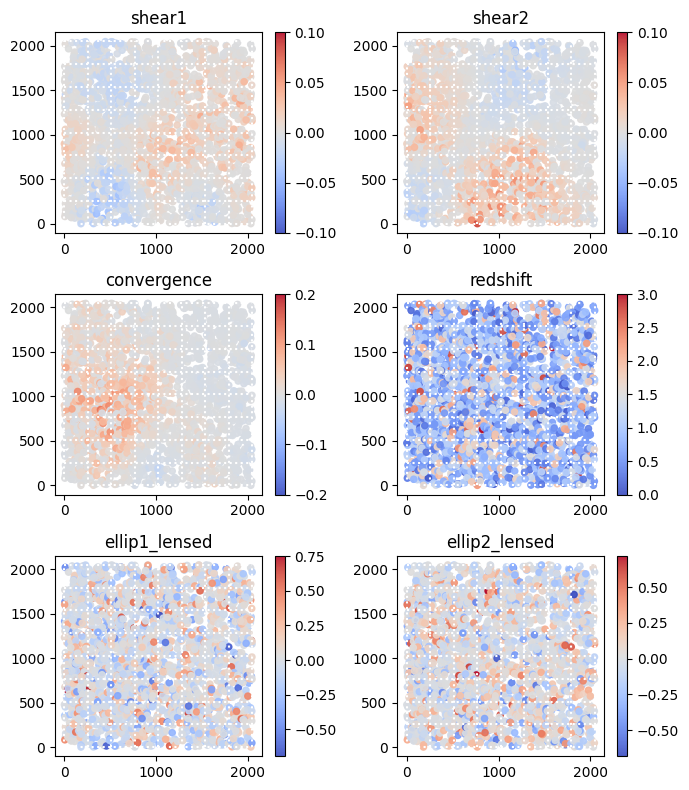

In [13]:
redshift_mask = (redshift.squeeze() > 0) & ((plocs.squeeze() <= 2048).all(dim=-1))
print(f'num galaxies = {redshift_mask.sum()}')
plot_maps_by_redshift(redshift_mask)

##### $z \in [2.5, 3]$

num galaxies = 29


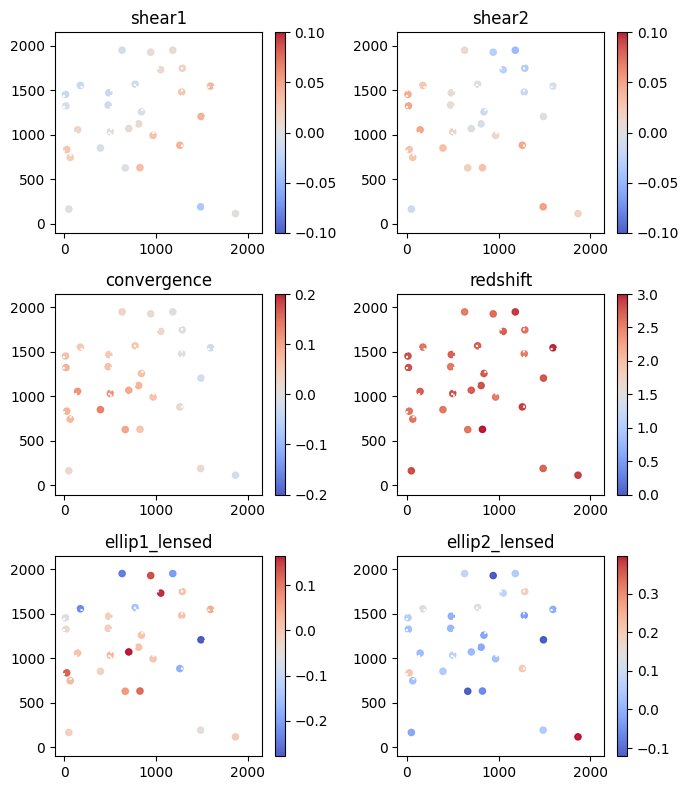

In [14]:
redshift_mask = (redshift.squeeze() >= 2.5) & (redshift.squeeze() < 3.0) & ((plocs.squeeze() <= 2048).all(dim=-1))
print(f'num galaxies = {redshift_mask.sum()}')
plot_maps_by_redshift(redshift_mask)

##### $z \in [2, 2.5]$

num galaxies = 58


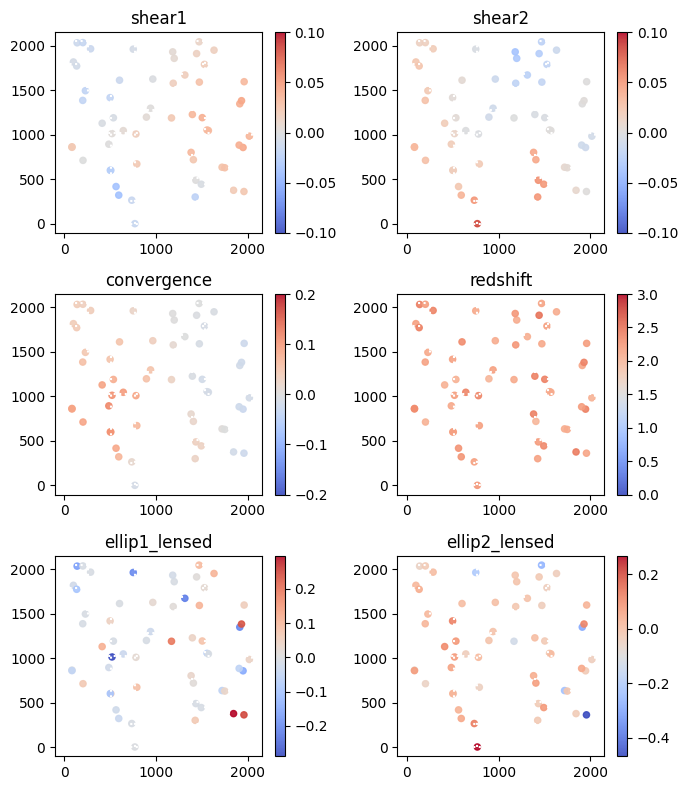

In [15]:
redshift_mask = (redshift.squeeze() >= 2.0) & (redshift.squeeze() < 2.5) & ((plocs.squeeze() <= 2048).all(dim=-1))
print(f'num galaxies = {redshift_mask.sum()}')
plot_maps_by_redshift(redshift_mask)

##### $z \in [1.5, 2]$

num galaxies = 235


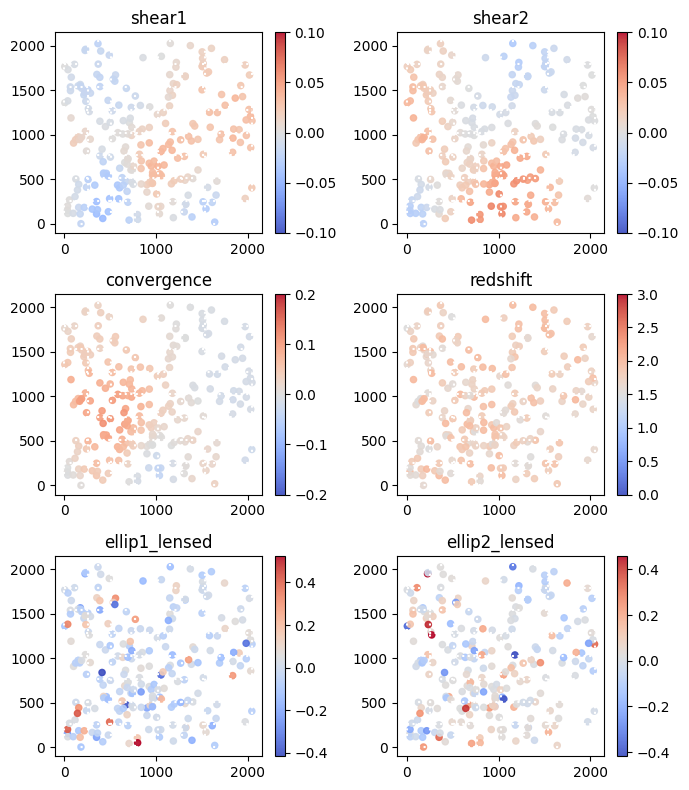

In [16]:
redshift_mask = (redshift.squeeze() >= 1.5) & (redshift.squeeze() < 2.0) & ((plocs.squeeze() <= 2048).all(dim=-1))
print(f'num galaxies = {redshift_mask.sum()}')
plot_maps_by_redshift(redshift_mask)

##### $z \in [1, 1.5]$

num galaxies = 742


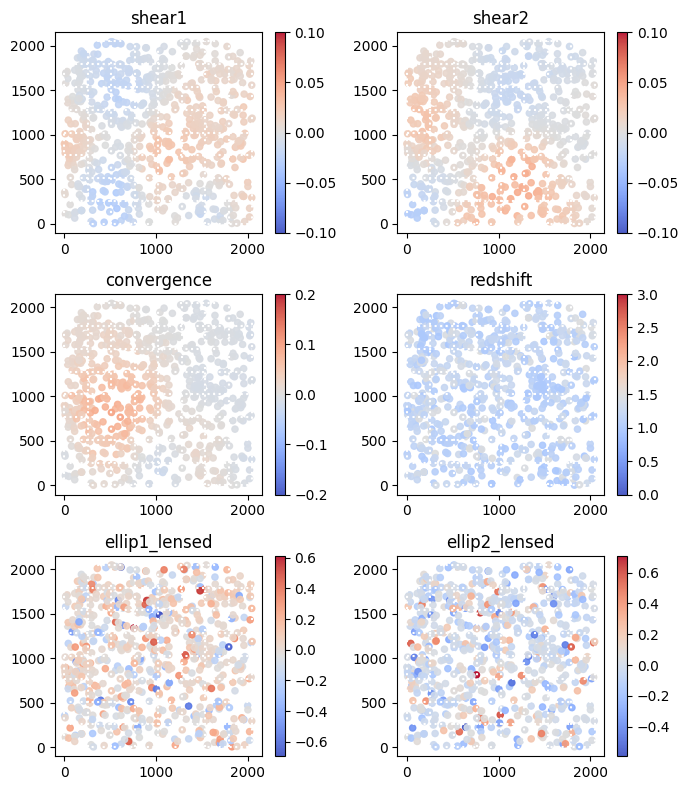

In [17]:
redshift_mask = (redshift.squeeze() >= 1.0) & (redshift.squeeze() < 1.5) & ((plocs.squeeze() <= 2048).all(dim=-1))
print(f'num galaxies = {redshift_mask.sum()}')
plot_maps_by_redshift(redshift_mask)

##### $z \in [0.5, 1]$

num galaxies = 1091


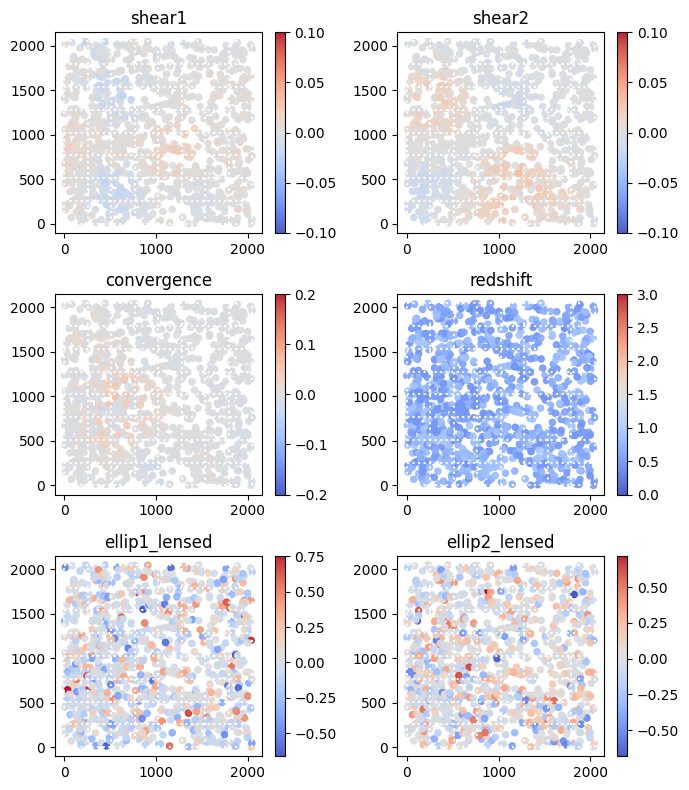

In [18]:
redshift_mask = (redshift.squeeze() >= 0.5) & (redshift.squeeze() < 1.0) & ((plocs.squeeze() <= 2048).all(dim=-1))
print(f'num galaxies = {redshift_mask.sum()}')
plot_maps_by_redshift(redshift_mask)

##### $z \in [0, 0.5]$

num galaxies = 381


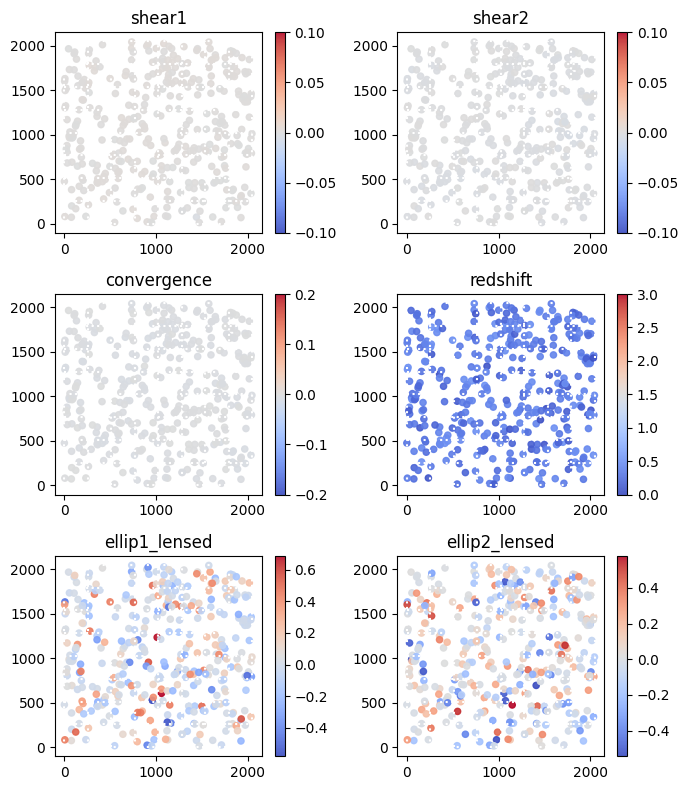

In [19]:
redshift_mask = (redshift.squeeze() >= 0.0) & (redshift.squeeze() < 0.5) & ((plocs.squeeze() <= 2048).all(dim=-1))
print(f'num galaxies = {redshift_mask.sum()}')
plot_maps_by_redshift(redshift_mask)